# Boosting and AdaBoost

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases [1].

## Table of Contents

1. [Introduction](#intro)
2. [Import Libraries](#libraries)
3. [Sample Dataset](#sample)
4. [Manual Implementation](#manual)
5. [Using Sklearn Library](#sklearn)
6. [Iris Dataset](#iris)
7. [Conclusion](#conclusion)

## 1. Introduction<a id='intro'></a>

In this study, we'll implement the Adaptive Boosting algorithm manually as descibed in the Master Machine Learnin Algorothms book [2]. We'll use randomly generated datasets for this. Then we'll use the `AdaBoostClassifier` function of `sklearn` library. Finally we'll use the same function to predict the class of famous Iris dataset.

## 2. Import Libraries<a id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')
from sklearn.datasets import make_circles
import math as m # to calculate log_e a.k.a. ln 

## 3. Sample Dataset<a id='sample'></a>

The dataset contains two input variables ($x_1$ and $x_2$) and the class output variable with the values 0 and 1. The dataset contains 10 records, 5 that belong to each class.

In [2]:
x1 = [3.64754035, 2.612663842, 2.363359679, 4.932600453, 3.776154753, 
      8.673960793, 5.861599451, 8.984677361, 7.467380954, 4.436284412]
x2 = [2.996793259, 4.459457779, 1.506982189, 1.299008795, 3.157451378, 
      2.122873405, 0.003512817, 1.768161009, 0.187045945, 0.862698005]
y = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

df = pd.DataFrame(zip(x1, x2, y), columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,3.647540,2.996793,0
1,2.612664,4.459458,0
2,2.363360,1.506982,0
3,4.932600,1.299009,0
4,3.776155,3.157451,0
5,8.673961,2.122873,1
6,5.861599,0.003513,1
7,8.984677,1.768161,1
8,7.467381,0.187046,1
9,4.436284,0.862698,1


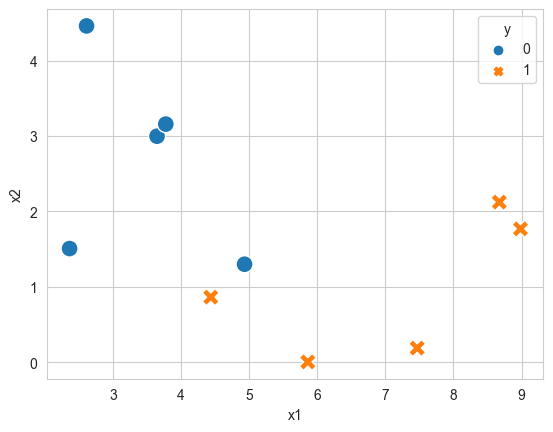

In [3]:
sb.scatterplot(data=df, x='x1', y='x2', hue='y', style='y', s=150)
plt.show()

## 4. Manual Implementation<a id='manual'></a>

### Training one model

Each instance in the training dataset is weighted. The initial weight is set to:

$$weight(x_i) = \frac{1}{n}$$

Where $x_i$ is the $i$’th training instance and $n$ is the number of training instances.

Then, Misclassification Rate is calculated as follow:

$$Misclassification Rate = \frac{\sum_{i=1}^n(w_i \times error_i)}{\sum_{i=1}^nw}$$

Where $w$ is the weight for training instance $i$ and $error$ is the prediction error for training instance $i$ which is 1 if misclassified and 0 if correctly classified.

A stage value is calculated for the trained model which provides a weighting for any predictions that the model makes. The stage value for a trained model is calculated as follows:

$$stage = ln(\frac{1 - Misclassification Rate}{Misclassification Rate})$$

Where stage is the stage value used to weight predictions from the model, $ln()$ is the natural logarithm.

In [4]:
def create_model(dataframe, split, feature):
    df_model = dataframe.copy()
    df_model[['Group', 'Prediction', 'Error']] = np.nan
    df_model.loc[df_model[feature] <= split, 'Group'] = 'LEFT'
    df_model.loc[df_model[feature] > split, 'Group'] = 'RIGHT'
    if df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'Group'] == 'RIGHT' and df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'y'] == 0:
        right = 0
        left = 1
    if df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'Group'] == 'RIGHT' and df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'y'] == 1:
        right = 1
        left = 0
    if df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'Group'] == 'LEFT' and df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'y'] == 0:
        right = 1
        left = 0
    if df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'Group'] == 'LEFT' and df_model[(df_model['Group'] == 'RIGHT')].mode().loc[0, 'y'] == 1:
        right = 0
        left = 1

    df_model.loc[df_model['Group'] == 'LEFT', 'Prediction'] = left
    df_model.loc[df_model['Group'] == 'RIGHT', 'Prediction'] = right

    df_model.loc[df_model['y'] == df_model['Prediction'], 'Error'] = 0
    df_model.loc[df_model['y'] != df_model['Prediction'], 'Error'] = 1

    acc = (1 - (df_model['Error'].sum() / len(df))) * 100
    
    return df_model, acc

In [5]:
def train(nr_iter, dataframe):
    df_train = pd.DataFrame(columns=['x1', 'x2', 'y', 'Weight', 'Group', 'Prediction', 
                                     'Error', 'Weighted_Error'])
    sum_weight = []
    sum_error = []
    missclassification = []
    stages = []
    accuracy = []
    
    # Below values are from the book. 
    # These values are used to check if the pyhton implementation generates the same results as the book.
    # splits = [4.932600453, 2.122873405, 0.862698005]
    # features = ['x1', 'x2', 'x2']
    
    # Generate random indexes and features
    splits = np.random.choice(np.arange(0, len(dataframe)), size=nr_iter, replace=False)
    features = np.random.choice(np.arange(1, 2+1), size=nr_iter, replace=True)

    for i in range(0, nr_iter):
        feature = 'x' + str(features[i])
        split = dataframe.loc[splits[i], feature]
        result = create_model(dataframe, split, feature)
        df_temp = result[0]
        acc = result[1]
        if i == 0:
            df_temp['Weight'] = 1 / len(dataframe)
        else:
            for j in range(0, len(df_temp)):
                df_temp.loc[j, 'Weight'] = df_train.loc[j+(i-1), 'Weight'] * np.exp(stages[i-1] * df_train.loc[j+(i-1), 'Weighted_Error'])
            
        df_temp['Weighted_Error'] = df_temp['Weight'] * df_temp['Error']
        # Calculate the sum of weights for the temp dataframe and added to the related list
        sw = df_temp['Weight'].sum() 
        sum_weight.append(sw)
        # Calculate the sum of errors for the temp dataframe and added to the related list
        se = df_temp['Weighted_Error'].sum()
        sum_error.append(se)
        # Calculate the missclassification rate for the temp dataframe and added to the related list
        mc = se / sw
        missclassification.append(mc)
        # Calculate the stage value and added to the related list
        st = m.log(((1-mc)/mc), np.e)
        stages.append(st)
        
        # Add the return model to the overall training dataframe
        df_train = pd.concat([df_train, df_temp], ignore_index=True)

        accuracy.append(acc)
    
    return df_train, accuracy, stages

In [6]:
result = train(5, df)
# Print the overlall training dataframe
result[0]

,x1,x2,y,Weight,Group,Prediction,Error,Weighted_Error
0,3.647540,2.996793,0,0.100000,LEFT,1.0,1.0,0.100000
1,2.612664,4.459458,0,0.100000,RIGHT,0.0,0.0,0.000000
2,2.363360,1.506982,0,0.100000,LEFT,1.0,1.0,0.100000
3,4.932600,1.299009,0,0.100000,LEFT,1.0,1.0,0.100000
4,3.776155,3.157451,0,0.100000,LEFT,1.0,1.0,0.100000
5,8.673961,2.122873,1,0.100000,LEFT,1.0,0.0,0.000000
6,5.861599,0.003513,1,0.100000,LEFT,1.0,0.0,0.000000
7,8.984677,1.768161,1,0.100000,LEFT,1.0,0.0,0.000000
8,7.467381,0.187046,1,0.100000,LEFT,1.0,0.0,0.000000
9,4.436284,0.862698,1,0.100000,LEFT,1.0,0.0,0.000000


In [7]:
# Print the accuracy score of each iteration
result[1]

[60.0, 90.0, 80.0, 70.0, 70.0]

### Prediction

In [8]:
def predict(df_input, df_train, stages):
    df = df_input.copy()
    features = []
    for i in range(0, len(stages)):
        feature = 'Model' + str(i+1)
        features.append(feature)
        df[feature] = ''
        for j in range(0, len(df_input)):
            multiplier = 1
            
            if df_train.loc[((i*10)+j), 'Prediction'] != 1:
               multiplier = -1 
            
            df.loc[j, feature] = stages[i] * multiplier
    
    df['Sum'] = df[features].sum(axis=1)
    
    df.loc[df['Sum'] > 0, 'Prediction'] = 1
    df.loc[df['Sum'] <= 0, 'Prediction'] = 0
    
    df.loc[df['Prediction'] == df['y'], 'Error'] = 0
    df.loc[df['Prediction'] != df['y'], 'Error'] = 1
    
    acc = (1 - (df['Error'].sum() / len(df))) * 100
    
    return df, acc

In [9]:
prediction = predict(df, result[0], result[2])
print('Accuracy: {:.2f}%'.format(prediction[1]))

Accuracy: 90.00%


### Another Sample Data

As you can see the proposed algorithm predicts the labels with 100% accuracy score for the sample dataset. We'll create a new dataset using the `make_circles` with 10% of `noise` to spice things up and check the performance of the Bagged Decision Tree algorithm. The dataset contains two input variables ($x_1$ and $x_2$) and the class output variable with the values 0 and 1. The dataset contains 100 records, 50 that belong to each class.

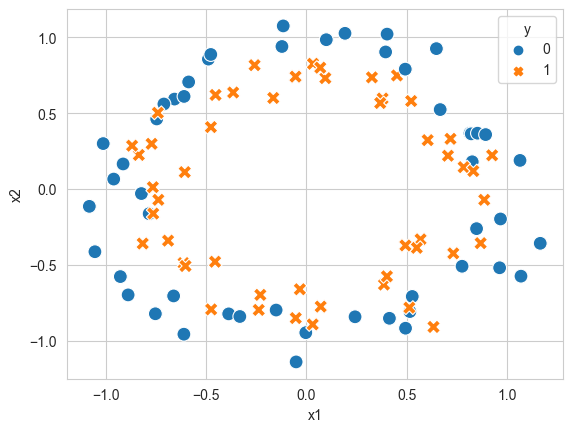

In [10]:
x, y = make_circles(n_samples=100, random_state=101, noise=0.1)

# Turn the features into new dataframe
df_new_sample = pd.DataFrame(zip(x[:,0], x[:,1], y), columns=['x1', 'x2', 'y'])

# Plot the features
sb.scatterplot(data=df_new_sample, x='x1', y='x2', hue='y', style='y', s=100)
plt.show()

In [11]:
result_new = train(3, df_new_sample)
result_new[0]

,x1,x2,y,Weight,Group,Prediction,Error,Weighted_Error
0,-0.489114,0.856099,0,0.010000,RIGHT,1.0,1.0,0.01
1,0.827368,0.179709,0,0.010000,RIGHT,1.0,1.0,0.01
2,0.516329,-0.807108,0,0.010000,RIGHT,1.0,1.0,0.01
3,-0.365443,0.636141,1,0.010000,RIGHT,1.0,0.0,0.00
4,-0.032702,-0.660047,1,0.010000,RIGHT,1.0,0.0,0.00
...,...,...,...,...,...,...,...,...
295,0.069168,0.799748,1,0.010000,RIGHT,1.0,0.0,0.00
296,-0.741245,0.502296,1,0.010000,RIGHT,1.0,0.0,0.00
297,-0.455790,-0.478902,1,0.010012,RIGHT,1.0,0.0,0.00
298,0.192513,1.026008,0,0.010000,RIGHT,1.0,1.0,0.01


In [12]:
result_new[1]

[-370.0, -370.0, -350.0]

### Predicting using new sample dataset

In [13]:
prediction = predict(df_new_sample, result_new[0], result_new[2])
print('Accuracy: {:.2f}%'.format(prediction[1]))

Accuracy: 48.00%


🔎 **Observation:**

## 5. Using Sklearn Library<a id='sklearn'></a>

We'll use the `AdaBoostClassifier` function from the `sklearn` library and check the accuracy score on the same randomly generated dataset.

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [15]:
model = AdaBoostClassifier()
model.fit(x, y)
y_hat = model.predict(x)
acc = accuracy_score(y, y_hat) * 100
print('Accuracy: {:.2f}%'.format(acc))

Accuracy: 97.00%


🔎 **Observation:**

## 6. Iris Dataset<a id='iris'></a>

We'll classify the flowers in the wellknown Iris dataset using `AdaBoostClassifier` from `sklearn` library.

In [16]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
dataset = pd.read_csv(url, names=names)
dataset.head()

,sepal-length,sepal-width,petal-length,petal-width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


[]

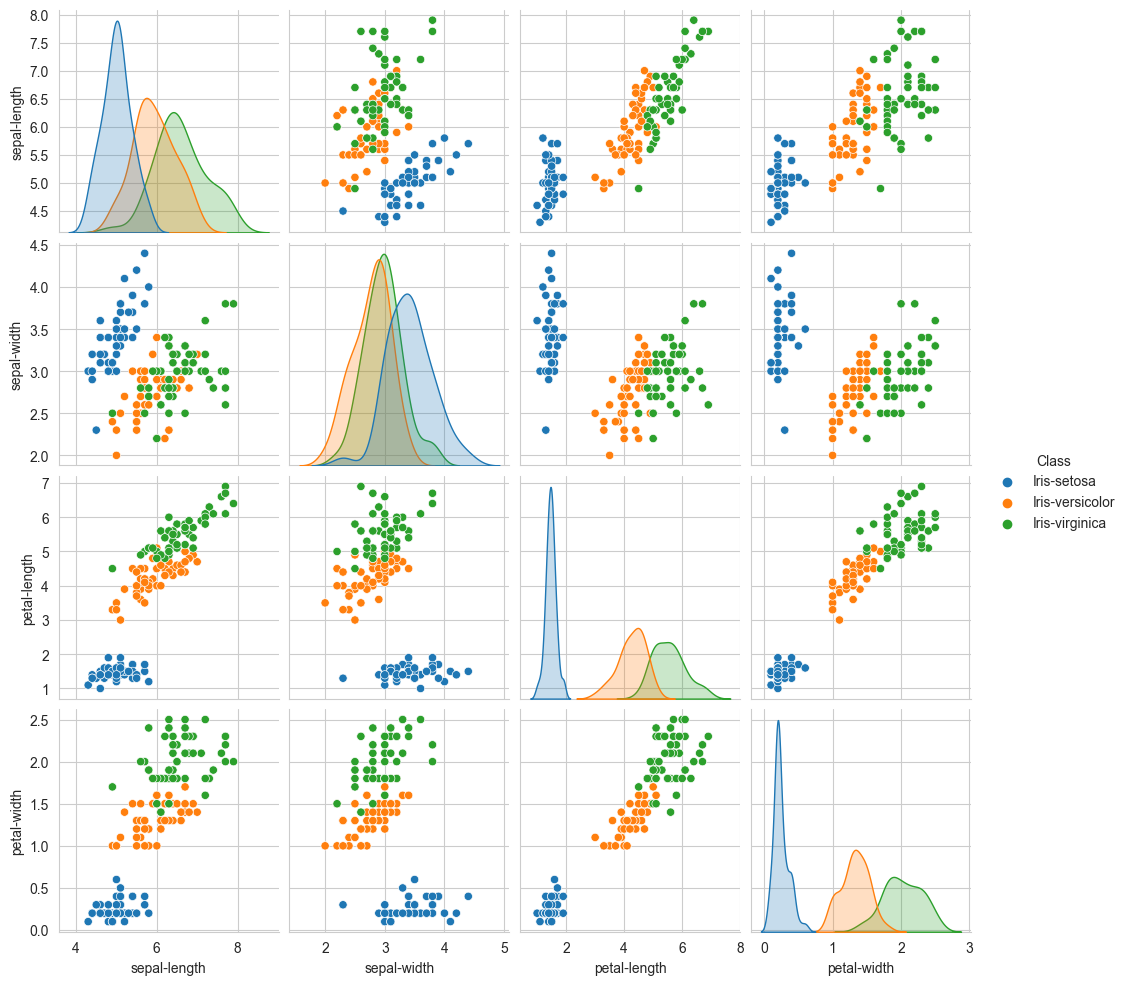

In [17]:
sb.pairplot(data=dataset, hue='Class', height=2.5)
plt.plot()

In [18]:
dataset.replace({'Class':{'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}}, inplace=True)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Set the features
x = dataset.drop('Class', axis=1)
# Set the label
y = dataset['Class']

# Split the dataset into train and test subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

In [21]:
model = AdaBoostClassifier()
model.fit(x_train, y_train)

y_hat = model.predict(x_test)

acc = accuracy_score(y_test, y_hat) * 100
print('Accuracy: {:.2f}'.format(acc))

Accuracy: 86.67


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.75      1.00      0.86        12
           2       1.00      0.50      0.67         8

    accuracy                           0.87        30
   macro avg       0.92      0.83      0.84        30
weighted avg       0.90      0.87      0.85        30



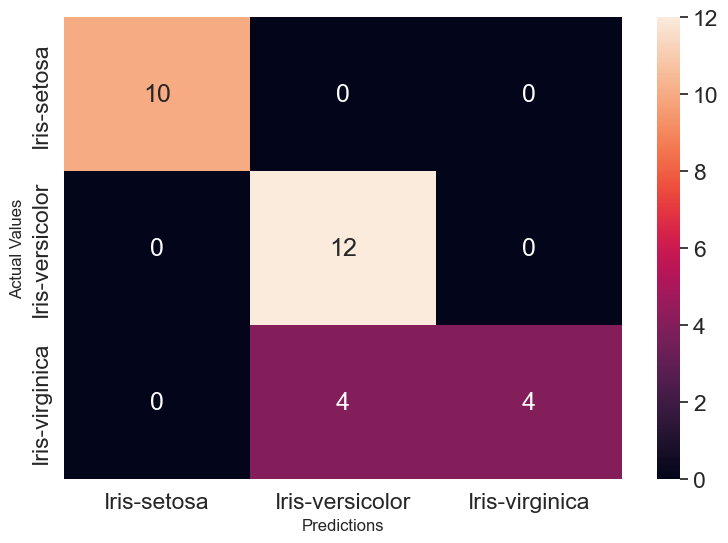

In [24]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_hat)
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
pred_labels = [l for l in labels]
cm_df = pd.DataFrame(cm, index=labels, columns=pred_labels)

sb.set(font_scale=1.5)
plt.figure(figsize=(9,6))
sb.heatmap(cm_df, annot=True, fmt='d')
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actual Values', fontsize=12)
plt.show()

## 7. Conclusion<a id='conclusion'></a>

Overall, AdaBoost is a powerful and flexible algorithm that can be applied to a wide range of problems, and has been shown to be highly effective in practice.

## References
---

[1] [sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

[2] [Master Machine Learning Algorithms](https://machinelearningmastery.com/master-machine-learning-algorithms/)